### Helmholz

In [3]:
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import polars as pl
import plotly.graph_objects as go
from tmm.tmm import TMM
from scipy.io import loadmat

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

data = pl.read_csv("lp_media_medicao1.csv")


class TMM(TMM):
    def helmholtz_layer(self, t=100, d=10, v_radius=100, method="eq_fluid", layer=None):
        """
        Adds layer representing a Helmholtz ressonator to the existing device.

        Parameters
        ----------
        t : float or int, optional
            Width of the ressonator bottleneck [mm]
        d : int or float
            Bottleneck diameter [mm]
        v_radius: int or float
            Volume radius of the ressonator cavity [mm]
        method : string, optional
            Chooses between the available methods to calculate resistive losses.
        layer : None or int, optional
            Optional value to choose the layer level. If None is passed the layer will be adding to the existing ones.
        """

        # Adjusting units
        t_meters = t / 1000
        d_meters = d / 1000
        v_radius_meters = v_radius / 1000
        v = (4 / 3) * np.pi * v_radius_meters**3
        bottleneck_area = np.pi * (d_meters**2) / 4
        t_corr = t_meters + 0.85 * (d_meters / 2)  # equivalent length
        rm = 0
        if method is None:  # no losses, so expected absorption is zero
            kc = np.sqrt(self.k0**2 - self.k0**2 * np.sin(np.deg2rad(self.incidence_angle)))
            rho_c = self.rho0
        elif method == "eq_fluid":  # Zwikker and Kosten viscothermic losses
            kc, zc = self.viscothermal_circular(d_meters, open_area=1)
            rho_c = (zc * self.w0) / (kc * (self.c0) ** 2)
        elif method == "ingard":  # additional Rm term to account for losses
            kc = np.sqrt(self.k0**2 - self.k0**2 * np.sin(np.deg2rad(self.incidence_angle)))
            rho_c = self.rho0
            rm = 0.00166 * np.sqrt(self.freq) * ((t_corr + 0.5 * d_meters) / (self.rho0 * self.c0 * 0.5 * d_meters)) + (
                (self.rho0 * self.c0 * self.k0**2 * bottleneck_area) / (2 * np.pi)
            )
        else:
            raise AttributeError("method not available.")

        # Helmholtz ressonator impedance
        zr = rm + 1j * (
            self.c0 * kc * rho_c * t_corr - ((rho_c * (self.c0) ** 2 * bottleneck_area) / (v * self.c0 * kc))
        )

        zr = matlib.repmat(zr, len(self.incidence_angle), 1).T
        ones = np.ones_like(self.freq, shape=(len(self.freq), len(self.incidence_angle)))
        zeros = np.zeros_like(self.freq, shape=(len(self.freq), len(self.incidence_angle)))

        # create parallel ressonator matrix
        Ta = np.array([[ones, zeros], [bottleneck_area / zr, ones]])

        if layer is None:
            layer = len(self.matrix)

        self.matrix[layer] = {
            "type": "helmholtz_layer",
            "thickness [mm]": t,
            "tube_diameter [mm]": d,
            "volume_radius [mm]": v_radius,
            "matrix": Ta,
        }

In [4]:
helmholtz = TMM(fmin=100, fmax=9200, df=1, incidence="normal", filename="helmholtz")
# specify device front termination area
helmholtz.s0 = 0.1

helmholtz.helmholtz_layer(t=100, d=32, v_radius=70, method="eq_fluid")

# Compute, plot and export data
helmholtz.compute(rigid_backing=True, show_layers=True)
helmholtz.save2sheet(n_oct=3)
helmholtz.save()
bands, filtered_alpha = helmholtz.filter_alpha(view=False, n_oct=3)

Device properties:
	(1 - Front face)
	(2 - Rear Face)
	Sound incidence: normal
	Angle: 0°

Layer 1:
	type:  helmholtz_layer
	thickness [mm]: 100.00 | thickness [inches]: 3.94
	tube_diameter [mm]: 32.00 | tube_diameter [inches]: 1.26
	volume_radius [mm]: 70.00 | volume_radius [inches]: 2.76
Layer 2:
	type:  backing
	rigid_backing:  True
	impedance_conjugate:  False

Total treatment depth [mm]: 100.00 | Total treatment depth [inches]: 3.94
Sheet saved to  /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/helmholtz.xlsx
HDF5 file saved at /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/helmholtz.h5


### Placa perfurada

Device properties:
	(1 - Front face)
	(4 - Rear Face)
	Sound incidence: normal
	Angle: 0°

Layer 1:
	type:  perforated_panel_layer
	thickness [mm]: 15.00 | thickness [inches]: 0.59
	hole_diameter [mm]: 2.00 | hole_diameter [inches]: 0.08
	hole_spacing [mm]: 18.00 | hole_spacing [inches]: 0.71
	open_area [%]: 0.97
	end_correction:  jb
	rho [kg/m3]: None
	method:  eq_fluid
Layer 2:
	type:  porous_layer
	flow_resistivity [k*Pa*s/m²]: 3.71
	thickness [mm]: 50.00 | thickness [inches]: 1.97
	model:  mac
Layer 3:
	type:  air_layer
	thickness [mm]: 30.00 | thickness [inches]: 1.18
Layer 4:
	type:  backing
	rigid_backing:  True
	impedance_conjugate:  False

Total treatment depth [mm]: 95.00 | Total treatment depth [inches]: 3.74
Sheet saved to  /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/placa_perfurada_1.xlsx
HDF5 file saved at /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/placa_perfurada_1.h5


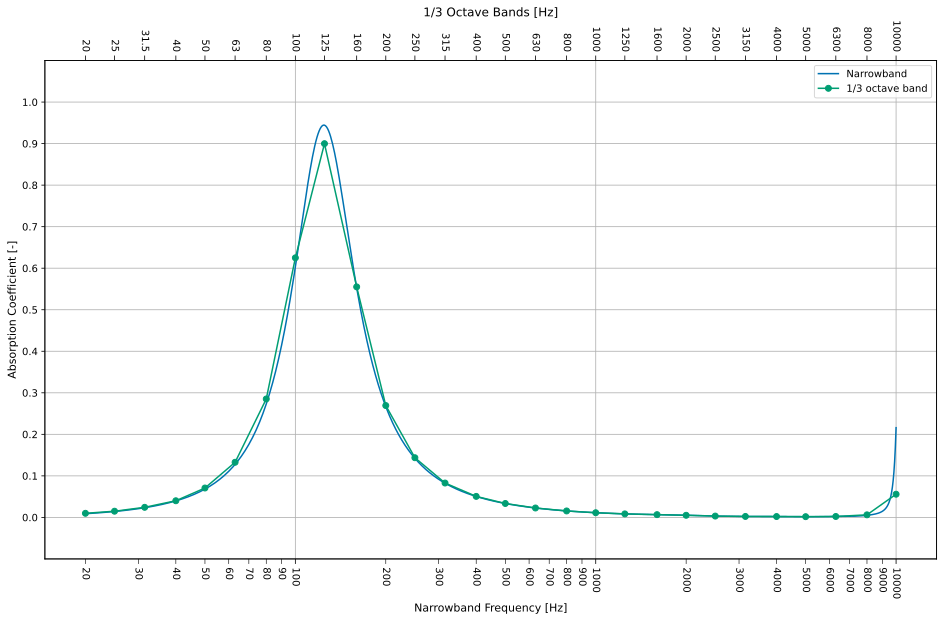

In [5]:
# Define the frequency range, resolution and sound incidence
perforated_panel_1 = TMM(fmin=20, fmax=10000, df=1, incidence="normal", filename="placa_perfurada_1")

# Define the layers - from top to bottom
perforated_panel_1.perforated_panel_layer(t=15, d=2, s=18, method="eq_fluid")  # Use Zwikker&Kosten method
perforated_panel_1.porous_layer(model="mac", t=50, sigma=3.71)  # Allard-Champoux model
perforated_panel_1.air_layer(t=30)

# Compute, plot and export data
perforated_panel_1.compute(rigid_backing=True, show_layers=True)
# perforated_panel_1.plot(plots=["alpha"], save_fig=True)
perforated_panel_1.save2sheet(n_oct=3)
perforated_panel_1.save()
bands, filtered_alpha = perforated_panel_1.filter_alpha(view=True, n_oct=3)

Device properties:
	(1 - Front face)
	(3 - Rear Face)
	Sound incidence: normal
	Angle: 0°

Layer 1:
	type:  perforated_panel_layer
	thickness [mm]: 15.00 | thickness [inches]: 0.59
	hole_diameter [mm]: 8.00 | hole_diameter [inches]: 0.31
	hole_spacing [mm]: 16.00 | hole_spacing [inches]: 0.63
	open_area [%]: 19.63
	end_correction:  jb
	rho [kg/m3]: None
	method:  eq_fluid
Layer 2:
	type:  porous_layer
	flow_resistivity [k*Pa*s/m²]: 3.71
	thickness [mm]: 50.00 | thickness [inches]: 1.97
	model:  mac
Layer 3:
	type:  backing
	rigid_backing:  True
	impedance_conjugate:  False

Total treatment depth [mm]: 65.00 | Total treatment depth [inches]: 2.56
Sheet saved to  /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/placa_perfurada_2.xlsx
HDF5 file saved at /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/placa_perfurada_2.h5


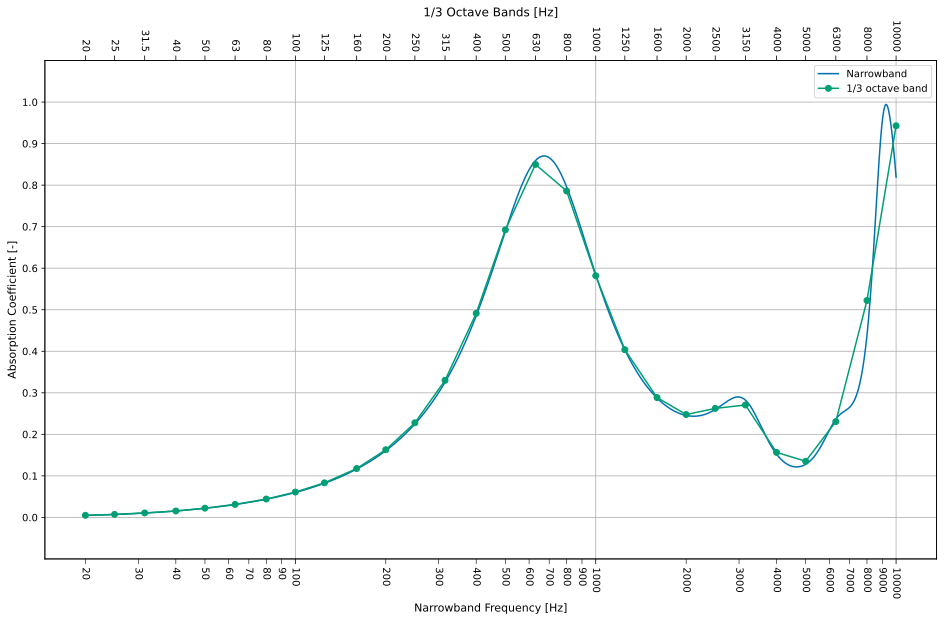

In [6]:
# Define the frequency range, resolution and sound incidence
perforated_panel_2 = TMM(fmin=20, fmax=10000, df=1, incidence="normal", filename="placa_perfurada_2")

# Define the layers - from top to bottom
perforated_panel_2.perforated_panel_layer(t=15, d=8, s=16, method="eq_fluid")  # Use Zwikker&Kosten method
perforated_panel_2.porous_layer(model="mac", t=50, sigma=3.71)  # Allard-Champoux model

# Compute, plot and export data
perforated_panel_2.compute(rigid_backing=True, show_layers=True)
# perforated_panel_2.plot(plots=["alpha"], save_fig=True)
perforated_panel_2.save2sheet(n_oct=3)
perforated_panel_2.save()
bands, filtered_alpha = perforated_panel_2.filter_alpha(view=True, n_oct=3)

### Amortecedor de vibrações

In [7]:
experiment_data = loadmat("experimento_modulo_elasticidade/amostra5_espuma_nova_whitenoise/Hf.mat")

freq = experiment_data["freqh"]
Hf_abs = np.abs(experiment_data["Hf"])

mask = freq.flatten() < 100

max_amplitude = Hf_abs.max()
max_freq = freq[Hf_abs.argmax()]
half_power_band_amplitude = max_amplitude / np.sqrt(2)

results = {
    "amostra1_espuma_melamina_cinza": {"fn": 50.4, "f1": 48.8, "f2": 52.3, "l": 13e-3, "d": 26.72e-3},
    "amostra1_espuma_melamina_cinza2": {"fn": 53.9, "f1": 53.0, "f2": 54.8, "l": 13e-3, "d": 26.72e-3},
    "amostra1_espuma_melamina_cinza3": {"fn": 57.2, "f1": 56.0, "f2": 57.9, "l": 13e-3, "d": 26.72e-3},
    "amostra2_espuma_cinza": {"fn": 18.2, "f1": 17.8, "f2": 19.5, "l": 26.04e-3, "d": 28.03e-3},
    "amostra3_espuma_cinza_escuro_pinknoise": {"fn": 39.6, "f1": 36.4, "f2": 42.0, "l": 11.98e-3, "d": 27.66e-3},
    "amostra3_espuma_cinza_escuro_whitenoise": {"fn": 39.5, "f1": 36.4, "f2": 41.3, "l": 11.98e-3, "d": 27.66e-3},
    "amostra4_la_pet_pinknoise": {"fn": 17.7, "f1": 17.3, "f2": 19.1, "l": 12e-3, "d": 27.22e-3},
    "amostra4_la_pet_whitenoise": {"fn": 23.6, "f1": 23.0, "f2": 24.0, "l": 12e-3, "d": 27.22e-3},
    "amostra5_espuma_nova_pinknoise": {"fn": 58.5, "f1": 57.5, "f2": 60.3, "l": 15.30e-3, "d": 27.74e-3},
    "amostra5_espuma_nova_whitenoise": {"fn": 58.4, "f1": 57.2, "f2": 59.9, "l": 15.30e-3, "d": 27.74e-3},
}

fig = go.Figure(data=go.Scatter(x=freq.flatten()[mask], y=Hf_abs.flatten()[mask], mode="lines+markers"))
fig.update_xaxes(type="log")
fig.update_yaxes(type="log")

fig.add_hline(y=(half_power_band_amplitude))
fig.show()

In [8]:
m = 63.53e-2  # [kg] mass of accelerometer + base

df = pl.DataFrame([{"sample": k, **v} for (k, v) in results.items()])
# (pl.col("f1") * (2*np.pi)).pow(2) * m

elasticity_modulus = df.with_columns(
    ((np.pi * pl.col("d")) / 4).alias("area"), (pl.col("fn") * (2 * np.pi)).alias("wn")
).with_columns(
    ((pl.col("wn").pow(2) * m * pl.col("l")) / pl.col("area")).alias("elasticity_modulus"),
    ((pl.col("f2") - pl.col("f1")) / (pl.col("fn"))).alias("loss_factor"),
)

In [9]:
elasticity_modulus

sample,fn,f1,f2,l,d,area,wn,elasticity_modulus,loss_factor
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""amostra1_espuma_melamina_cinza""",50.4,48.8,52.3,0.013,0.02672,0.020986,316.672539,39465.415734,0.069444
"""amostra1_espuma_melamina_cinza…",53.9,53.0,54.8,0.013,0.02672,0.020986,338.663688,45137.04666,0.033395
"""amostra1_espuma_melamina_cinza…",57.2,56.0,57.9,0.013,0.02672,0.020986,359.3982,50833.225393,0.033217
"""amostra2_espuma_cinza""",18.2,17.8,19.5,0.02604,0.02803,0.022015,114.353973,9826.737813,0.093407
"""amostra3_espuma_cinza_escuro_p…",39.6,36.4,42.0,0.01198,0.02766,0.021724,248.814138,21689.209556,0.141414
"""amostra3_espuma_cinza_escuro_w…",39.5,36.4,41.3,0.01198,0.02766,0.021724,248.18582,21579.806403,0.124051
"""amostra4_la_pet_pinknoise""",17.7,17.3,19.1,0.012,0.02722,0.021379,111.21238,4410.505506,0.101695
"""amostra4_la_pet_whitenoise""",23.6,23.0,24.0,0.012,0.02722,0.021379,148.283173,7840.898677,0.042373
"""amostra5_espuma_nova_pinknoise""",58.5,57.5,60.3,0.0153,0.02774,0.021787,367.56634,60276.137781,0.047863


In [ ]:
m = 0.265  # mass [kg]
E = 60e3  # young's modulus [Pa]
b = 67.5e-3  # length [m]
w = 16e-3  # width [m]

A = b * w  # area [m^2]
L = 0.01  # width [m]
k = (E * A) / L  # stiffness [N/m]

etas = np.array([0.046])  # loss factor

w_n = np.sqrt(k / m)  # natural frequecy [rad/s]
freq = np.arange(1, 2000, 1)
w = 2 * np.pi * freq

fig, ax = plt.subplots(figsize=(10, 6))
for eta in etas:
    kc = k * (1 + 1j * eta)
    Tf = np.abs(kc / (kc - w**2 * m))
    ax.loglog(freq, Tf, label=rf"$\eta = {eta}$")

ax.grid(linestyle="--", which="major")
ax.set_xlabel("Frequência [Hz]")
ax.set_ylabel(r"$\left|T_f\right|$ [-]")
ax.set_xlim((freq[0], freq[-1]))
ax.axvline(x=(w_n / (2 * np.pi)), linestyle="--", color="magenta")
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

x = data.select("f").to_numpy().flatten()
height = data.select("NPS").to_numpy().flatten()

edges_between_points = np.sqrt(x[:-1] * x[1:])
log_x = np.log(x)
first_edge_dist = (log_x[1] - log_x[0]) / 2
last_edge_dist = (log_x[-1] - log_x[-2]) / 2
first_edge = np.exp(log_x[0] - first_edge_dist)
last_edge = np.exp(log_x[-1] + last_edge_dist)
all_edges = np.concatenate(([first_edge], edges_between_points, [last_edge]))
widths = np.diff(all_edges)
left_edges = all_edges[:-1]

plt.bar(
    left_edges,
    height,
    width=widths,
    align="edge",
    facecolor="dodgerblue",
    edgecolor="black",
    lw=1,
    label="$L_p$ médio",
    alpha=0.2,
)
ax.set_xscale("log")
ax.set_ylabel(r"NPS [dB]")
ax.set_xlabel("Frequência [Hz]")
ax.set_xlim((all_edges[0], all_edges[-1]))

ax2 = ax.twinx()
ax2.semilogx(helmholtz.freq, helmholtz.alpha, c="k", label=r"Helmholtz: $t=100$ [mm]; $d=32$ [mm], $V_r=70$ [mm]")
ax2.semilogx(
    perforated_panel_1.freq,
    perforated_panel_1.alpha,
    label="PP 1: $t=15$ [mm]; $d=2$ [mm]; $s=18$ [mm]; $d_{pet}=50$ [mm]; $g=30$ [mm]",
)
ax2.semilogx(
    perforated_panel_2.freq,
    perforated_panel_2.alpha,
    label="PP 2: $t=15$ [mm]; $d=8$ [mm]; $s=16$ [mm]; $d_{pet}=50$ [mm]",
)

ax2.set_ylim(0, 1)
ax2.set_ylabel(r"$\alpha$ [-]")

fig.legend(loc="lower right", bbox_to_anchor=(1, 0), bbox_transform=ax.transAxes)
plt.savefig("Treatments/simulacao_inicial.svg", format="svg", bbox_inches="tight")
plt.show()

NameError: name 'plt' is not defined